In [94]:
# Imports & stuff

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from cycler import cycler

# Constants
time = 3200
discount = 0.99
pres_sarsop = []
pres_ub = []
# all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag", "Hallway1", "Hallway2", "MiniHallway", "TigerGrid"] # All envs
# all_envs = ["ABC", "Tiger", "RockSample5", "RockSample10", "K-out-of-N2", "K-out-of-N3", 
#             "FrozenLake4", "FrozenLake10", "Tag",  "SparseHallway1", "SparseHallway2", "SparseTigerGrid"] # Messing around...
all_envs = ["ABC", "Tiger", "RockSample5", "K-out-of-N2", "K-out-of-N3", 
            "FrozenLake4", "FrozenLake10", "Tag",  "SparseHallway1", "SparseHallway2", "SparseTigerGrid"] # Messing around...
Env_to_latex_name = {
    "ABC" : "\\custom",
    "Tiger":"\\tiger",
    "RockSample5": "\\rocksample (5)",
    "RockSample10": "\\rocksample (10)",
    "K-out-of-N2":"\\koutofn (2)",
    "K-out-of-N3":"\\koutofn (3)",
    "FrozenLake4":"\\lake (4)",
    "FrozenLake10":"\\lake (10)",
    "Tag":"\\tagenv",
    "Hallway1":"\\hallway1",
    "Hallway2":"\\hallway2",
    "TigerGrid":"\\tigergrid",
    "SparseHallway1":"\\hallwayone",
    "SparseHallway2":"\\hallwaytwo",
    "SparseTigerGrid":"\\tigergrid",
    "MiniHallway":"\\minihallway"
}



# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4"] #Testing envs
# all_envs = ["ABC", "Tiger", "RockSample5", "FrozenLake4", "FrozenLake10", "K-out-of-N3"] #Testing envs
pre_sarsop = "./Data/SarsopTest/Sarsoptest_"
pre_ub = "./Data/UpperBounds/UpperBoundTest_"
post_sarsop = f"_t{time}_d{str(discount)[2:]}.json"
post_ub =f"_d{str(discount)[2:]}.json"
for env in all_envs:
    pres_sarsop.append(pre_sarsop + env + "_" )
    pres_ub.append(pre_ub + env + "_")

# solvers = ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]
solvers = ["SARSOP", "BIB-SARSOP", "EBIB-SARSOP"]
# solvers = ["SARSOP", "BIB-SARSOP"]

def get_data_plot(env:str):
    ts, ubs, lbs = [], [], []
    solvernames, envname = [], ""
    for s in solvers:
        with open(pre_sarsop+env+"_"+s+post_sarsop) as file:
            data = json.load(file)
            ts.append(data["times"])
            ubs.append(data["ubs"])
            lbs.append(data["lbs"])
            solvernames.append(data["solver"])
            envname = data["env_full"]

    return ts, ubs, lbs, solvernames, envname

### Plotting

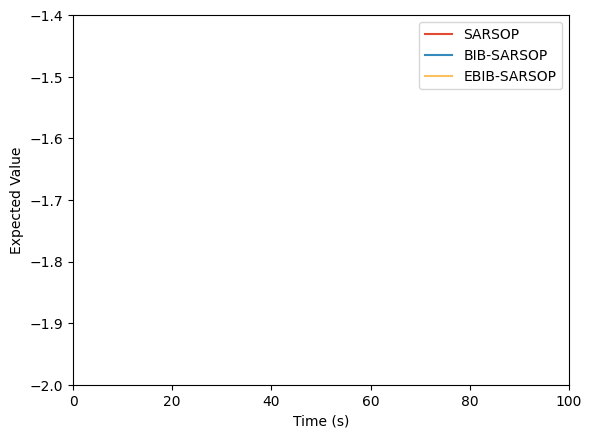

In [92]:
# TigerGrid

ts, ubs, lbs, solvernames, envname = get_data_plot("FrozenLake10")

colours =  ['#E24A33', '#348ABD',  '#FBC15E', '#8EBA42', '#FFB5B8']

# colours = [(226, 74, 51), (52, 138, 189), (152, 142, 213)]

for (i,label) in enumerate(solvernames):
    plt.plot(ts[i][1:],ubs[i][1:], label=label, color=colours[i], linestyle="-")
    plt.plot(ts[i][1:],lbs[i][1:], label=None, color=colours[i], linestyle="--")
plt.xlabel("Time (s)")
plt.ylabel("Expected Value")
plt.ylim(-2, -1.4)
plt.xlim(0,100)
plt.legend()
plt.show()

### Tables

In [95]:
# SARSOP Convergence times

def get_vars_sarsop(data:dict):
    if data["timeout"]:
        # diff =  abs((data["final_ub"] - data["final_lw"] ) / data["final_lw"])
        diff = abs(data["final_ub"] - data["final_lw"])
        return f' TO ({diff:.2f})'
        return f'- ({data["final_lw"]:.2f}, {data["final_ub"]:.2f})'
    else:
        return f'{data["runtime"]:.2f}s'


# labels = ["\\SARSOP", "\\BIBSARSOP", "\\EBIBSARSOP"]
labels = ["None", "\\BIB", "\\EBIB"]
names = []
Sarsop_time, BibSarsop_time, EBibSarsop_time = [], [], []
Sarsop_its, BibSarsop_its, EBibSarsop_its = [], [], []

for thispre in pres_sarsop:
    filename_Sarsop = thispre + "SARSOP" + post_sarsop
    # print(pre)
    with open(filename_Sarsop) as file:
        this_data = json.load(file)
        # names.append(this_data["env_full"])
        names.append(Env_to_latex_name[this_data["env"]])
        Sarsop_time.append(get_vars_sarsop(this_data))
        Sarsop_its.append(len(this_data["times"]))
        # print("Sarsop: ", len(this_data["times"]))

    filename_BibSarsop = thispre + "BIB-SARSOP" + post_sarsop
    with open(filename_BibSarsop) as file:
        this_data = json.load(file)
        BibSarsop_time.append(get_vars_sarsop(this_data))
        BibSarsop_its.append(len(this_data["times"]))
        # print("BIBSarsop: ", len(this_data["times"]))

    filename_EBibSarsop = thispre + "EBIB-SARSOP" + post_sarsop
    with open(filename_EBibSarsop) as file:
        this_data = json.load(file)
        EBibSarsop_time.append(get_vars_sarsop(this_data))
        EBibSarsop_its.append(len(this_data["times"]))
        # print("BIBSarsop: ", len(this_data["times"]))

dataframe = pd.DataFrame([Sarsop_time, BibSarsop_time, EBibSarsop_time], index=labels, columns=names).transpose()

# dataframe = pd.DataFrame([Sarsop_its, BibSarsop_its, EBibSarsop_its], index=labels, columns=names).transpose()


print(dataframe)

print(dataframe.to_latex(column_format="l|ccc"))

                        None         \BIB        \EBIB
\custom                4.13s        3.30s        8.13s
\tiger                56.79s        8.36s        6.41s
\rocksample (5)       16.04s      341.10s      319.59s
\koutofn (2)       TO (1.42)    TO (0.76)    TO (0.76)
\koutofn (3)       TO (3.66)    TO (2.45)    TO (2.47)
\lake (4)              2.88s        3.67s        6.75s
\lake (10)            54.72s      128.09s      160.52s
\tagenv           TO (12.85)   TO (93.79)   TO (93.80)
\hallwayone        TO (1.79)    TO (1.40)    TO (1.44)
\hallwaytwo        TO (4.74)    TO (4.39)    TO (4.43)
\tigergrid         TO (4.44)    TO (3.78)    TO (3.94)
\begin{tabular}{l|ccc}
\toprule
 & None & \BIB & \EBIB \\
\midrule
\custom & 4.13s & 3.30s & 8.13s \\
\tiger & 56.79s & 8.36s & 6.41s \\
\rocksample (5) & 16.04s & 341.10s & 319.59s \\
\koutofn (2) &  TO (1.42) &  TO (0.76) &  TO (0.76) \\
\koutofn (3) &  TO (3.66) &  TO (2.45) &  TO (2.47) \\
\lake (4) & 2.88s & 3.67s & 6.75s \\
\lake (1

In [91]:
# Upper bounds

def get_vars_ub(data:dict):
    if data["solver"] == "SARSOP":
        # return f'{data["ub"]:.2f}, ({data["solvetime"]:.1f}s)'
        if data["solvetime"] < 60:
            return f'{data["ub"]:.2f}*'
        else:
            return f'{data["ub"]:.2f}'
    else:
        return f'{data["ub"]:.2f} ({data["solvetime"]:.1f}s)'

heuristic_names = ["FIB", "BIB", "EBIB", "WBIB", "SARSOP"]
labels = ["\\FIB", "\\BIB", "\\EBIB", "\\OBIB", "\\SARSOP"]
# heuristic_names = ["FIB", "BIB", "EBIB", "SARSOP"]
# labels = ["\\FIB", "\\BIB", "\\EBIB", "\\SARSOP"]
env_names = []
bounds = []
for _h in heuristic_names:
    bounds.append([])

for (env_idx, thispre) in enumerate(pres_ub):
    env_names.append("...")
    for (heur_idx, name) in enumerate(heuristic_names):
        filename = thispre + name + post_ub
        try:
            with open(filename) as file:
                this_data = json.load(file)

                if env_names[env_idx] == "...":
                    env_names[env_idx] = Env_to_latex_name[this_data["env"]]

                bounds[heur_idx].append(get_vars_ub(this_data))
        except:
                bounds[heur_idx].append("TO")

print(bounds)
print(env_names)
print(labels)

dataframe = pd.DataFrame( bounds, index=labels, columns=env_names).transpose()

print(dataframe)

print(dataframe.to_latex(column_format="l|ccccc"))




[['0.79 (1.5s)', '449.35 (0.9s)', '23.48 (7.7s)', '26.46 (49.0s)', '-6.02 (2.4s)', '-9.11 (14.2s)', '0.94 (1.4s)', '0.88 (7.9s)', '-5.13 (62.9s)', '7.87 (62.1s)', '5.84 (67.4s)', '14.10 (12.1s)'], ['0.66 (2.3s)', '263.86 (1.2s)', '23.48 (224.9s)', '26.46 (16541.3s)', '-6.90 (6.7s)', '-10.38 (431.1s)', '0.93 (3.3s)', '0.87 (72.7s)', '-6.55 (6227.7s)', '7.43 (354.6s)', '5.46 (767.1s)', '13.57 (151.1s)'], ['0.50 (4.9s)', '218.34 (2.8s)', '23.48 (222.7s)', 'TO', '-6.88 (9.0s)', '-10.34 (574.7s)', '0.93 (5.3s)', '0.87 (77.8s)', '-6.53 (6156.5s)', '7.41 (1306.0s)', '5.45 (2160.4s)', '13.55 (863.3s)'], ['0.50 (96.5s)', '218.34 (33.1s)', '23.48 (12034.9s)', 'TO', 'TO', 'TO', '0.93 (1545.1s)', 'TO', 'TO', 'TO', 'TO', 'TO'], ['0.49*', '107.12*', '23.29*', 'TO', '-6.81', '-9.24', '0.93*', '0.88', '-6.46', '7.87', '5.84', '13.92']]
['\\custom', '\\tiger', '\\rocksample (5)', '\\rocksample (10)', '\\koutofn (2)', '\\koutofn (3)', '\\lake (4)', '\\lake (10)', '\\tagenv', '\\hallwayone', '\\hallwaytw